In [2]:
import os.path as osp
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv, GATv2Conv, global_mean_pool, BatchNorm
from sklearn import metrics
import time
import matplotlib.pyplot as plt

In [3]:
# Load the PPI dataset and split it into training, validation, and test sets.
train_dataset = PPI('.', split='train')
val_dataset = PPI('.', split='val')  # Changed from 'test' to 'val' for validation set
test_dataset = PPI('.', split='test')

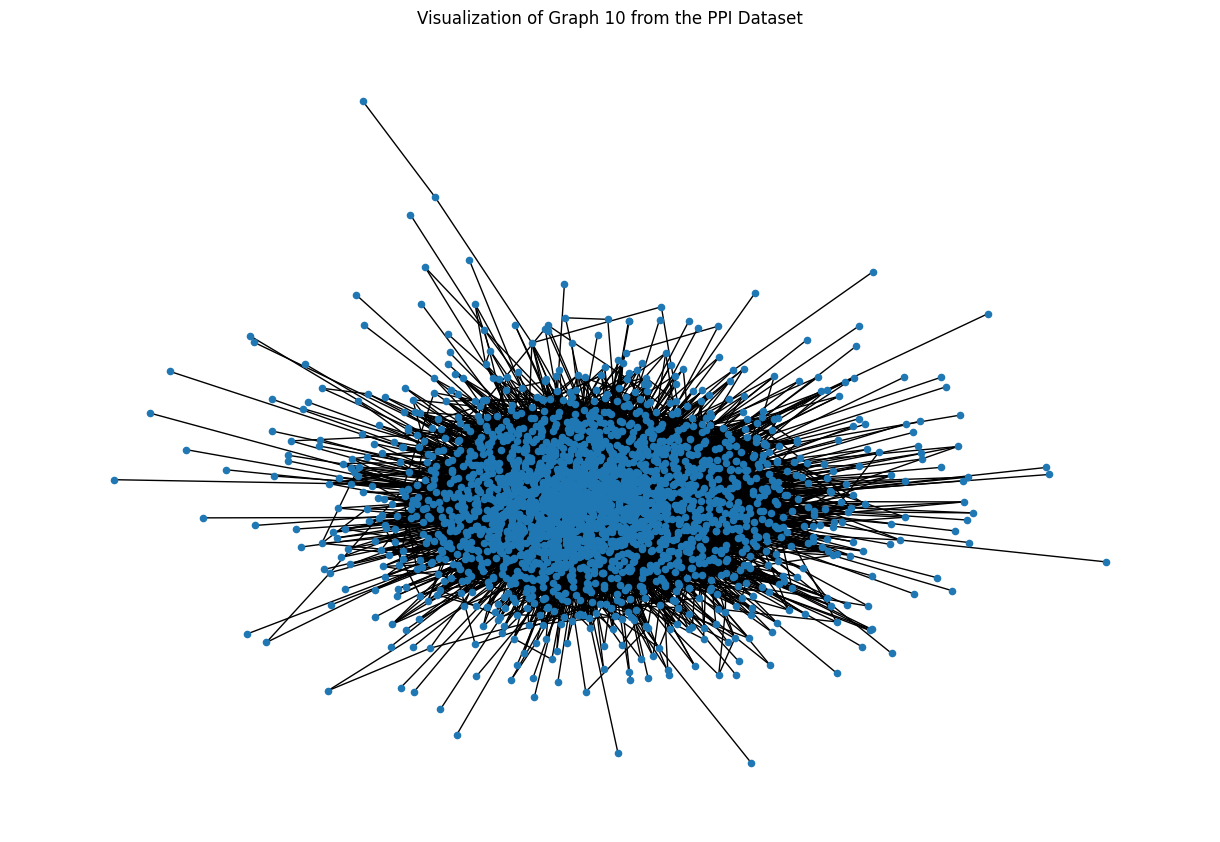

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

data0 = train_dataset[10]
# Create a NetworkX graph from the edge indices
G = nx.Graph()
edge_index = data0.edge_index.t().numpy()
G.add_edges_from(edge_index)
# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, node_size=20, with_labels=False)
plt.title("Visualization of Graph 10 from the PPI Dataset")
plt.show()

C:\Users\ariel\anaconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 01, Train Loss: 0.5636, Val Loss: 0.5164, Val Acc: 0.5090, Elapsed Time: 5.52 seconds
Epoch: 02, Train Loss: 0.5083, Val Loss: 0.4882, Val Acc: 0.5389, Elapsed Time: 9.87 seconds
Epoch: 03, Train Loss: 0.4847, Val Loss: 0.4844, Val Acc: 0.4817, Elapsed Time: 14.26 seconds
Epoch: 04, Train Loss: 0.4712, Val Loss: 0.4571, Val Acc: 0.5886, Elapsed Time: 18.62 seconds
Epoch: 05, Train Loss: 0.4440, Val Loss: 0.4460, Val Acc: 0.5945, Elapsed Time: 22.98 seconds
Epoch: 06, Train Loss: 0.4262, Val Loss: 0.4313, Val Acc: 0.6239, Elapsed Time: 27.33 seconds
Epoch: 07, Train Loss: 0.4229, Val Loss: 0.4114, Val Acc: 0.6505, Elapsed Time: 31.71 seconds
Epoch: 08, Train Loss: 0.3861, Val Loss: 0.3942, Val Acc: 0.6595, Elapsed Time: 36.10 seconds
Epoch: 09, Train Loss: 0.3635, Val Loss: 0.3751, Val Acc: 0.6906, Elapsed Time: 40.47 seconds
Epoch: 10, Train Loss: 0.3423, Val Loss: 0.3562, Val Acc: 0.7167, Elapsed Time: 44.82 seconds
Epoch: 11, Train Loss: 0.3248, Val Loss: 0.3437, Val Acc: 0.73

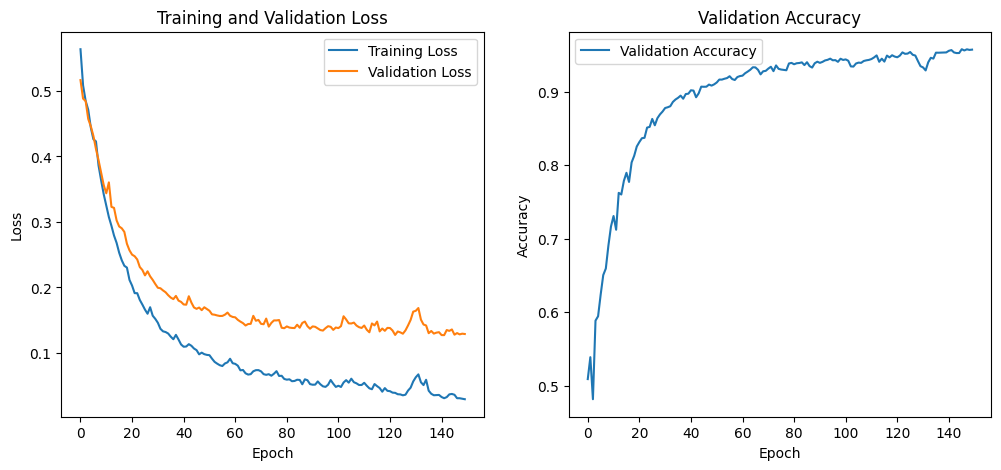

In [5]:
# Create data loaders for each dataset split.
train_loader = DataLoader(train_dataset, shuffle=True)
val_loader = DataLoader(val_dataset, shuffle=False)
test_loader = DataLoader(test_dataset, shuffle=False)

class Net(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Net, self).__init__()
        self.conv1 = GATConv(train_dataset.num_features, hidden_channels)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, hidden_channels)
        
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        
        self.conv3 = GATConv(hidden_channels, train_dataset.num_classes)
        self.lin3 = torch.nn.Linear(hidden_channels, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index)+self.lin1(x))
        x = F.elu(self.conv2(x, edge_index)+self.lin2(x))
        x = self.conv3(x, edge_index)+self.lin3(x)
        return x

    
# Setup the device for training (GPU or CPU).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(hidden_channels=256).to(device)

# Define the loss function(criterion) and optimizer.
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

def train(model, data_loader, optimizer, criterion):
    """
    Trains the GNN model for one epoch.
    
    Args:
        model: The GNN model to be trained.
        data_loader: DataLoader for the training dataset.
        optimizer: Optimizer for the model's parameters.
        criterion: Loss function used for training.

    Returns:
        Average training loss for the epoch.
    """
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in data_loader:
        batch_size = batch.num_graphs
        batch = batch.to(device)

        optimizer.zero_grad()
        predictions = model(batch.x, batch.edge_index)
        loss = criterion(predictions, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size

    average_loss = total_loss / len(data_loader.dataset)
    return average_loss


def test(model, data_loader, criterion):
    """
    Evaluates the GNN model.

    Args:
        model: The GNN model to be evaluated.
        data_loader: DataLoader for the dataset to evaluate.
        criterion: Loss function used for evaluation.

    Returns:
        Tuple of average loss and micro F1 score.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_micro_f1 = 0

    with torch.no_grad():
        for batch in data_loader:
            batch_size = batch.num_graphs
            batch = batch.to(device)

            predictions = model(batch.x, batch.edge_index)
            loss = criterion(predictions, batch.y)

            total_loss += loss.item() * batch_size
            predicted_labels = (predictions > 0).float().cpu()
            micro_f1 = metrics.f1_score(batch.y.cpu(), predicted_labels, average='micro')
            total_micro_f1 += micro_f1 * batch_size

    average_loss = total_loss / len(data_loader.dataset)
    average_micro_f1 = total_micro_f1 / len(data_loader.dataset)
    return average_loss, average_micro_f1


# Variables to store metrics for plotting
train_losses = []
val_losses = []
val_accuracies = []

# Training and evaluation loop
start_time = time.time() 
for epoch in range(1, 151):
    # Call train function with required arguments
    train_loss = train(model, train_loader, optimizer, criterion)
    
    # Call test function with required arguments for validation
    val_loss, val_acc = test(model, val_loader, criterion)
    
    # Store metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Calculate elapsed time
    elapsed_time = time.time() - start_time 
    print(f'Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Elapsed Time: {elapsed_time:.2f} seconds')

# Plotting
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


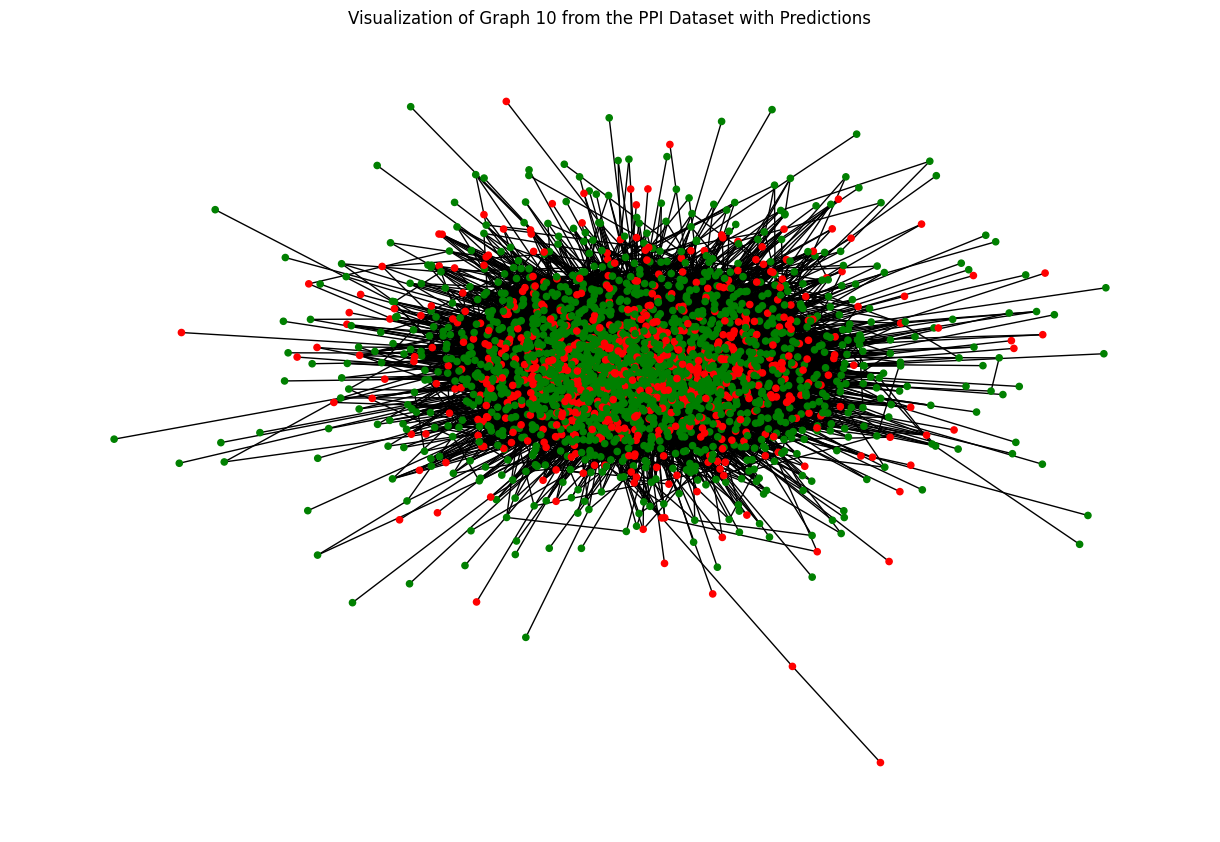

In [24]:
#Visualize the correctly predicted nodes

data0 = train_dataset[10]

# Get predictions for this graph
model.eval()
with torch.no_grad():
    predictions = model(data0.x, data0.edge_index)
    predicted_labels = (predictions > 0).float()

# Determine correct and incorrect predictions
correct_predictions = (predicted_labels == data0.y).all(dim=1)

# Create a NetworkX graph from the edge indices
G = nx.Graph()
edge_index = data0.edge_index.t().cpu().numpy()
G.add_edges_from(edge_index)

# Assign colors based on predictions
node_colors = ['green' if correct else 'red' for correct in correct_predictions]

# Draw the graph with colored nodes
plt.figure(figsize=(12, 8))
nx.draw(G, node_color=node_colors, node_size=20, with_labels=False)
plt.title("Visualization of Graph 10 from the PPI Dataset with Predictions")
plt.show()